# Análise Exploratória de Dados
## Importando bibliotecas

In [2]:
from src.data import prepare
from src.data import process
from src.data import visualize

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud
from PIL import Image

plt.style.use('seaborn-notebook')
%matplotlib inline

## Pré-processando os dados

In [3]:
true_path = "../data/raw/full_texts/true/"
fake_path = "../data/raw/full_texts/fake/"
output_path = "../data/interim/news.csv"

prepare.make_text_dataframe(true_path, fake_path, output_path)

## Importando dados pré-processados

In [4]:
news_df = pd.read_csv(output_path)
news_df.sample(10)

,text,label
1240,Projeções apontam para alta de ao menos 1% do ...,true
2075,Julgamento do recurso de Lula no TRF-4 ocorre ...,true
10,Esplanada dos Ministérios é fechada para Fórum...,true
1225,Conta de luz em novembro no Ceará terá tarifa ...,true
2219,Saiba como votou cada ministro do STF na decis...,true
6419,URGENTE: Juiz Sérgio Moro envia depoimento de ...,fake
111,Opções de contenção dos EUA na Coreia do Norte...,true
3004,Como o termo fake news virou arma nos dois lad...,true
6413,Você sabe quem é a funkeira Larissa Machado? V...,fake
747,Ao menos seis ficam feridos em confusão durant...,true


## Analisando os dados obtidos

### Quantidade de dados

In [5]:
news_df['label'].value_counts()

true    3600
fake    3600
Name: label, dtype: int64

*O número de dados do corpus utilizado está equilibrado. 
Há um número igual de textos verdadeiros (true) e falsos (fake).*

### Comprimento

#### De todo o texto

- Qual o comprimento dos textos obtidos?
- O comprimento dos textos difere entre falsos e verdadeiros?

In [6]:
news_df['text_length'] = news_df['text'].str.len()

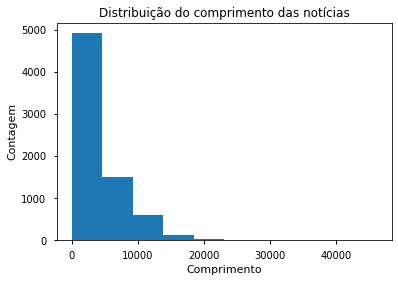

In [7]:
plt.hist(news_df.text_length)
plt.xlabel('Comprimento')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.show()

In [8]:
news_df.text_length.describe()

count     7200.000000
mean      3898.906250
std       4066.717133
min         46.000000
25%        948.000000
50%       2185.500000
75%       5603.250000
max      46084.000000
Name: text_length, dtype: float64

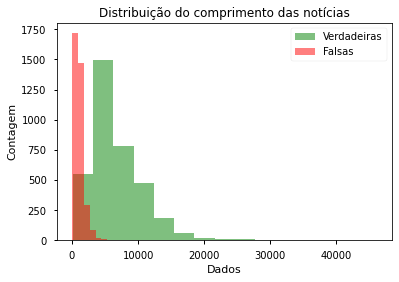

In [9]:
bins = 15
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].text_length,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].text_length,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.legend(loc='upper right')

plt.show()

*As notícias têm entre 46 e cerca de 46000 palavras, se distribuindo de maneira desigual de acordo com sua categoria. O comprimento das notícias verdadeiras tem tamanhos mais variados e mediana superior às notícias falsas, cujo comprimento se concentra numa faixa reduzida.* 

*Dentro desse conjunto de dados, notícias falsas tendem a ser mais curtas.*

#### Das palavras

- Há diferença no tamanho médio das palavras entre as diferentes categorias de notícias?

In [10]:
news_df['mean_word_len'] = (
    news_df['text']
    .str
    .split()
    .apply(lambda text : [len(word) for word in text])
    .map(lambda word: np.mean(word))
)

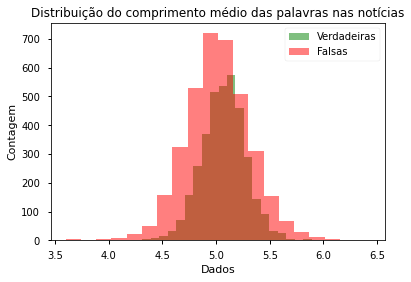

In [11]:
bins = 20
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento médio das palavras nas notícias')
plt.legend(loc='upper right')

plt.show()

*Não parece haver diferença no comprimento médio das palavras utilizadas nas notícias, quaisquer que sejam as categorias.*

### Nuvens de palavras
- As palavras mais usadas nas notícias abordadas estão dentro dos mesmos campos semânticos?

In [12]:
nltk.download('stopwords')
stop = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /home/tayna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


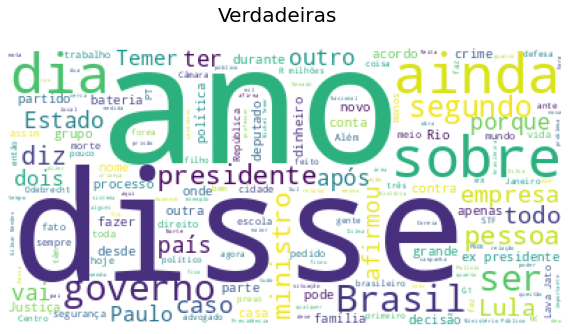

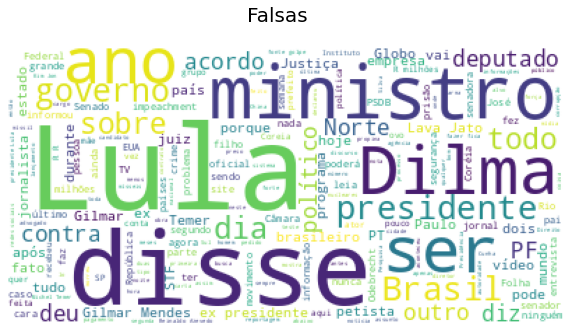

In [13]:
visualize.show_wordcloud(news_df[news_df.label == 'true'].text[0:100], 
               stop, title = 'Verdadeiras')

visualize.show_wordcloud(news_df[news_df.label == 'fake'].text[0:100], 
               stop, title = 'Falsas')

plt.show()

### N-gramas
- Em que contextos as palavras são usadas?

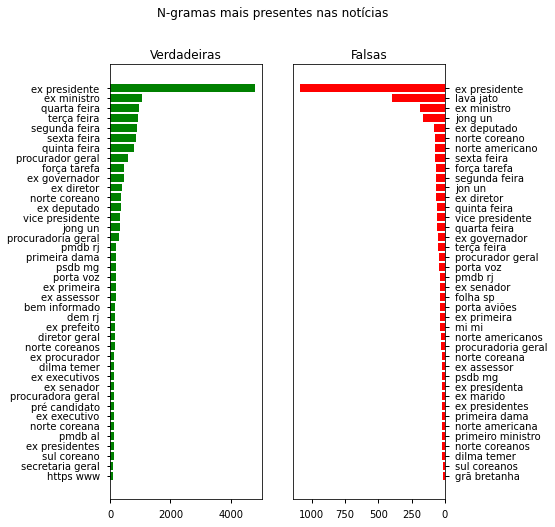

In [15]:
true_corpus = process.create_corpus(news_df[news_df.label == 'true'].text)
fake_corpus = process.create_corpus(news_df[news_df.label == 'fake'].text)

true_n_gram = process.get_top_ngram(corpus = true_corpus, n=2, top=40, stop_words=stop)
fake_n_gram = process.get_top_ngram(corpus = fake_corpus, n=2, top=40, stop_words=stop)

visualize.show_ngrams(true_n_gram, fake_n_gram)

Podemos observar que em ambas as categorias, se faz referência a "ex presidente" e a ocupantes anteriores de cargos ("ex ministro", "ex deputado", "ex diretor"). 

Nas notícias verdadeiras há uma *contaminação* de palavras relacionadas aos dias da semana. Há ainda referências a partidos (psdb, dem, pmdb), e a Coreia do norte em ambos os casos.

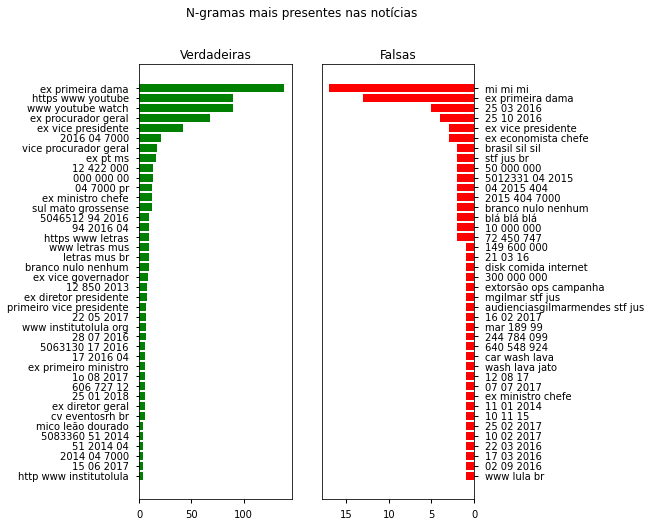

In [16]:
true_n_gram = process.get_top_ngram(corpus = true_corpus, n=3, top=40, stop_words=stop)
fake_n_gram = process.get_top_ngram(corpus = fake_corpus, n=3, top=40, stop_words=stop)

visualize.show_ngrams(true_n_gram, fake_n_gram)

Com a visualização em trigramas fica mais fácil observar a contaminação nos textos. Observamos 

- datas, ex: "28 07 2016", "16 02 2017"
- endereços eletrônicos 
    - aparentemente relacionados, ex: "www institutolula org"
    - aparentemente não relacionados, ex: "www letras mus"

Uma eliminação de números e endereços eletrônicos (palavras com www, https, etc) poderá melhorar a qualidade dos dados.